# Inpainting

## Load Image

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
cat = Image.open('images/cat1.jpeg').convert('L')
cat.save('images/cat1_gray.jpeg')

[[200 200 200 ... 197 197 198]
 [200 200 200 ... 198 198 199]
 [201 201 201 ... 198 198 199]
 ...
 [206 205 204 ... 188 189 182]
 [206 207 203 ... 184 190 178]
 [205 206 203 ... 183 182 174]]


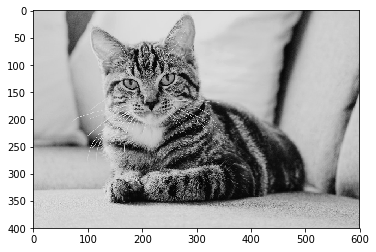

In [10]:
A = np.array(cat.resize([600, 400]))
print(A)
plt.imshow(A, cmap='gray')
plt.show()

[[0.78431373 0.78431373 0.78431373 ... 0.77254902 0.77254902 0.77647059]
 [0.78431373 0.78431373 0.78431373 ... 0.77647059 0.77647059 0.78039216]
 [0.78823529 0.78823529 0.78823529 ... 0.77647059 0.77647059 0.78039216]
 ...
 [0.80784314 0.80392157 0.8        ... 0.7372549  0.74117647 0.71372549]
 [0.80784314 0.81176471 0.79607843 ... 0.72156863 0.74509804 0.69803922]
 [0.80392157 0.80784314 0.79607843 ... 0.71764706 0.71372549 0.68235294]]


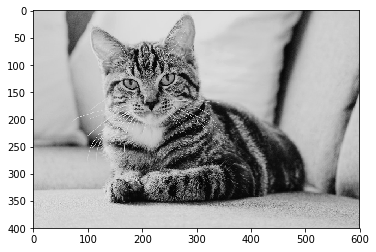

In [11]:
B = A/255
print(B)
plt.imshow(B, cmap='gray')
plt.show()

In [12]:
M = np.zeros_like(B).reshape(-1)
M[:M.shape[0]//2] = 1
np.random.shuffle(M)
M = M.reshape(B.shape)
print(M)

[[1. 0. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 1. 1.]
 [1. 0. 0. ... 1. 0. 0.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [0. 1. 0. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 0. 0.]]


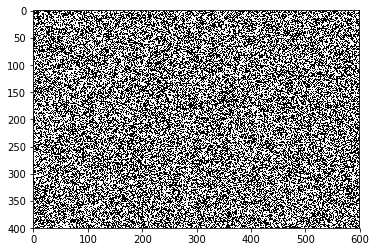

In [13]:
plt.imshow(M, cmap='gray')
plt.show()

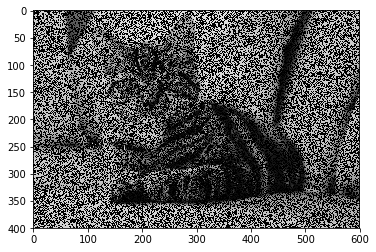

In [14]:
Y = M * B
plt.imshow(Y, cmap='gray', vmin=np.min(B), vmax=np.max(B))
plt.show()

In [158]:
cat_masked = Image.fromarray(np.uint8(Y*255))
cat_masked.save('images/cat1_gray_masked.jpeg')

## Gradient

In [8]:
import torch

In [51]:
Bt = torch.zeros(B.shape, requires_grad=True)
Mt = torch.tensor(M, requires_grad=False, dtype=torch.float)
Yt = torch.tensor(Y, requires_grad=False, dtype=torch.float)

loss = torch.sum((Yt - Bt*Mt)**2)

In [54]:
loss.backward(retain_graph=True)

In [12]:
Yt

tensor([[0.0000, 0.0000, 0.7843,  ..., 0.0000, 0.0000, 0.0000],
        [0.7843, 0.0000, 0.0000,  ..., 0.7725, 0.0000, 0.0000],
        [0.0000, 0.7843, 0.0000,  ..., 0.7765, 0.7804, 0.0000],
        ...,
        [0.0000, 0.0000, 0.8118,  ..., 0.7059, 0.0000, 0.0000],
        [0.7961, 0.0000, 0.8078,  ..., 0.0000, 0.6824, 0.0000],
        [0.0000, 0.7961, 0.0000,  ..., 0.6745, 0.6784, 0.6824]])

In [55]:
Bt.grad

tensor([[-0.0000, -0.0000, -1.5686,  ..., -0.0000, -0.0000, -0.0000],
        [-1.5686, -0.0000, -0.0000,  ..., -1.5451, -0.0000, -0.0000],
        [-0.0000, -1.5686, -0.0000,  ..., -1.5529, -1.5608, -0.0000],
        ...,
        [-0.0000, -0.0000, -1.6235,  ..., -1.4118, -0.0000, -0.0000],
        [-1.5922, -0.0000, -1.6157,  ..., -0.0000, -1.3647, -0.0000],
        [-0.0000, -1.5922, -0.0000,  ..., -1.3490, -1.3569, -1.3647]])

In [14]:
Yt

tensor([[0.0000, 0.0000, 0.7843,  ..., 0.0000, 0.0000, 0.0000],
        [0.7843, 0.0000, 0.0000,  ..., 0.7725, 0.0000, 0.0000],
        [0.0000, 0.7843, 0.0000,  ..., 0.7765, 0.7804, 0.0000],
        ...,
        [0.0000, 0.0000, 0.8118,  ..., 0.7059, 0.0000, 0.0000],
        [0.7961, 0.0000, 0.8078,  ..., 0.0000, 0.6824, 0.0000],
        [0.0000, 0.7961, 0.0000,  ..., 0.6745, 0.6784, 0.6824]])

In [15]:
C = -1/2*Bt.grad

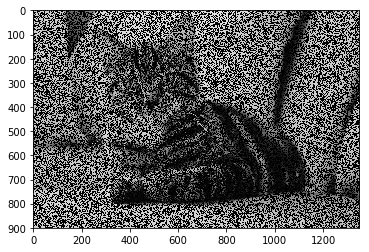

In [16]:
plt.imshow(C, cmap='gray')
plt.show()

In [17]:
torch.all(C == Yt)

tensor(1, dtype=torch.uint8)

## Wavelet

In [18]:
import pywt

In [19]:
B_wav = pywt.wavedec2(B, 'db4')

In [20]:
len(B_wav)

8

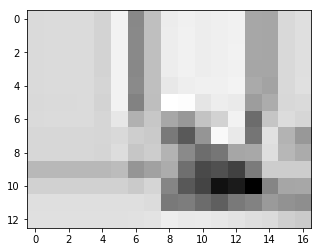

In [21]:
plt.imshow(B_wav[0], cmap='gray')
plt.show()

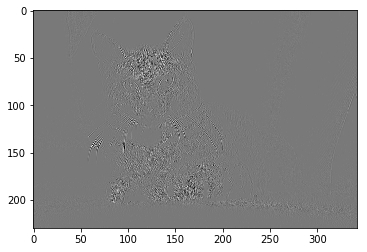

In [22]:
plt.imshow(B_wav[6][1], cmap='gray')
plt.show()

In [23]:
from numba import njit

In [24]:
@njit
def soft_thresholding(x, th):
    return np.sign(x) * np.maximum(np.abs(x)-th, 0)

In [25]:
soft_thresholding(B_wav[0], 20)

array([[80.24553827, 80.4480518 , 80.47103275, 80.76444947, 77.74654172,
        90.49543713, 44.74150127, 68.61500979, 88.14879492, 89.87211026,
        88.42565037, 89.48641808, 90.26000259, 57.92002243, 57.61439252,
        79.57910571, 82.22022846],
       [80.2345343 , 80.43745722, 80.46030553, 80.75384313, 77.73987204,
        90.46607777, 44.85153341, 68.43513004, 88.28881745, 89.9936188 ,
        88.54735836, 89.42716056, 90.38948613, 58.07523479, 57.52545683,
        79.58258847, 82.26599061],
       [80.25460019, 80.45756813, 80.48036329, 80.77411469, 77.76028812,
        90.48425337, 44.84395629, 68.37524896, 88.30156966, 90.00948664,
        88.56678411, 89.45117944, 90.4054583 , 57.9924356 , 57.5418364 ,
        79.58534723, 82.26388796],
       [80.23674073, 80.43969973, 80.46270112, 80.75755271, 77.73371679,
        90.4890268 , 44.70543845, 68.525884  , 88.55224336, 90.09559405,
        88.25128639, 89.40370307, 90.12932803, 57.81119694, 57.72239516,
        79.59202703

In [72]:
#@njit(parallel=True)
def wv_soft(x_wav, th):
    # x_wav[0] = soft_thresholding(x_wav[0], th)
    for i, coeffs in enumerate(x_wav):
        cH = soft_thresholding(coeffs[0], th)
        cV = soft_thresholding(coeffs[1], th)
        cD = soft_thresholding(coeffs[2], th)
        x_wav[i] = cH, cV, cD
    return x_wav

In [27]:
from copy import deepcopy

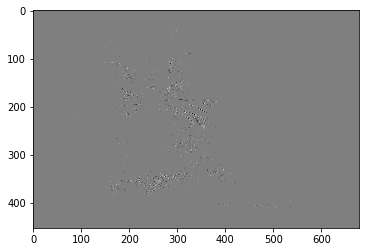

In [28]:
B_wav_c = deepcopy(B_wav)
B_wav_c_th = wv_soft(B_wav_c[1:], 0.1)
plt.imshow(B_wav_c_th[6][0], cmap='gray')
plt.show()

In [29]:
# with numba
%timeit B_wav_c_th = wv_soft(B_wav_c[1:], 0.1)

1000 loops, best of 3: 1.61 ms per loop


In [33]:
%load_ext line_profiler

In [43]:
def wv_soft2(x_wav, th):
    # x_wav[0] = soft_thresholding(x_wav[0], th)
    for i, coeffs in enumerate(x_wav):
        cH = soft_thresholding(coeffs[0], th)
        cV = soft_thresholding(coeffs[1], th)
        cD = soft_thresholding(coeffs[2], th)
        x_wav[i] = cH, cV, cD
    return x_wav

In [180]:
#without numba
%timeit B_wav_c_th = wv_soft2(B_wav_c[1:], 0.1)

1000 loops, best of 3: 1.29 ms per loop


In [44]:
%lprun -f wv_soft2 B_wav_c_th = wv_soft2(B_wav_c[1:], 0.1)

In [73]:
def wavelet_soft_thresholding(x, th, wavelet='db4'):
    x_wav = pywt.wavedec2(x, wavelet)
    x_wav[0] = soft_thresholding(x_wav[0], th)
    x_wav[1:] = wv_soft(x_wav[1:], th)
    return pywt.waverec2(x_wav, wavelet)

In [171]:
# with numba
%timeit B_th = wavelet_soft_thresholding(B, 0.1)

10 loops, best of 3: 68.3 ms per loop


In [164]:
# without numba
%timeit B_th = wavelet_soft_thresholding(B, 0.1)

10 loops, best of 3: 68.3 ms per loop


In [45]:
%lprun -f wavelet_soft_thresholding B_th = wavelet_soft_thresholding(B, 0.1)

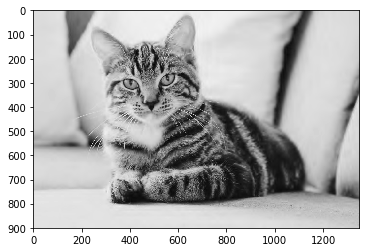

In [169]:
plt.imshow(B_th, cmap='gray')

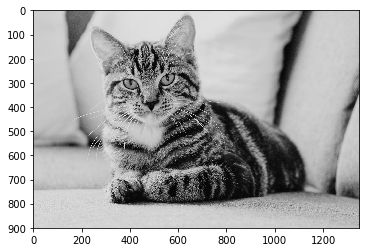

In [154]:
plt.imshow(B, cmap='gray')

## Forward Backward

In [190]:
import torch.optim

In [191]:
gamma = 1
lamb = 0.02
n_iters = 100

In [192]:
Bt = torch.zeros(B.shape, requires_grad=True)
Mt = torch.tensor(M, requires_grad=False, dtype=torch.float)
Yt = torch.tensor(Y, requires_grad=False, dtype=torch.float)

loss = torch.sum((Yt - Bt*Mt)**2)
optimizer = torch.optim.SGD([Bt], lr=0.1)

In [193]:
for _ in range(n_iters):
    optimizer.zero_grad()
    loss = torch.sum((Yt - Bt*Mt)**2)
    loss.backward(retain_graph=True)
    optimizer.step()
    Bt.data = torch.tensor(wavelet_soft_thresholding(Bt.detach().numpy(), lamb*gamma), dtype=torch.float)

In [196]:
Bt.data

tensor([[ 0.7874,  0.7874,  0.7874,  ...,  0.5482,  0.3652, -0.2160],
        [ 0.7874,  0.7874,  0.7874,  ...,  0.6822,  0.3881, -0.5125],
        [ 0.7874,  0.7874,  0.7874,  ...,  0.7157,  0.5652, -0.1942],
        ...,
        [ 0.8016,  0.8016,  0.8016,  ...,  0.6095,  0.5645,  0.5042],
        [ 0.8016,  0.8016,  0.8016,  ...,  0.6214,  0.5830,  0.5240],
        [ 0.8015,  0.8015,  0.8015,  ...,  0.6715,  0.6783,  0.6873]])

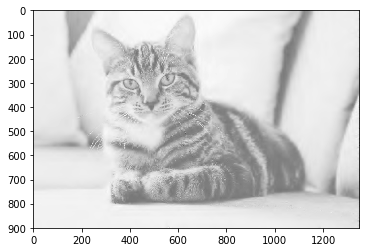

In [184]:
plt.imshow(Bt.detach().numpy(), cmap='gray')

In [185]:
cat_restored = Image.fromarray(np.uint8(Bt.detach().numpy()*255))

In [186]:
cat_restored.save('images/cat1_gray_inpainting.jpeg')

In [160]:
Bt.size()

torch.Size([900, 1350])

In [153]:
Bt.detach().numpy()

array([[0.7883644 , 0.7884659 , 0.78857195, ..., 0.7803347 , 0.7814696 ,
        0.7826551 ],
       [0.78835744, 0.7884595 , 0.788566  , ..., 0.7803188 , 0.7814521 ,
        0.78263605],
       [0.78835046, 0.788453  , 0.78856003, ..., 0.7803029 , 0.7814346 ,
        0.7826169 ],
       ...,
       [0.80260384, 0.8026107 , 0.80261755, ..., 0.6902525 , 0.6888523 ,
        0.6874285 ],
       [0.80271137, 0.80271834, 0.80272526, ..., 0.6902207 , 0.6888157 ,
        0.6873868 ],
       [0.8028704 , 0.8028774 , 0.80288434, ..., 0.6902803 , 0.6888614 ,
        0.68741804]], dtype=float32)

In [ ]:
class ForwardBackward(object):
    
    def __init__(self, gamma=0.1):
        self.gamma = gamma

In [59]:
Bt.grad

tensor([[-0.0000, -0.0000, -3.1373,  ..., -0.0000, -0.0000, -0.0000],
        [-3.1373, -0.0000, -0.0000,  ..., -3.0902, -0.0000, -0.0000],
        [-0.0000, -3.1373, -0.0000,  ..., -3.1059, -3.1216, -0.0000],
        ...,
        [-0.0000, -0.0000, -3.2471,  ..., -2.8235, -0.0000, -0.0000],
        [-3.1843, -0.0000, -3.2314,  ..., -0.0000, -2.7294, -0.0000],
        [-0.0000, -3.1843, -0.0000,  ..., -2.6980, -2.7137, -2.7294]])

In [205]:
torch.rand([20, 2]).type()

'torch.FloatTensor'

In [208]:
Bt.clone()

tensor([[ 0.7874,  0.7874,  0.7874,  ...,  0.5482,  0.3652, -0.2160],
        [ 0.7874,  0.7874,  0.7874,  ...,  0.6822,  0.3881, -0.5125],
        [ 0.7874,  0.7874,  0.7874,  ...,  0.7157,  0.5652, -0.1942],
        ...,
        [ 0.8016,  0.8016,  0.8016,  ...,  0.6095,  0.5645,  0.5042],
        [ 0.8016,  0.8016,  0.8016,  ...,  0.6214,  0.5830,  0.5240],
        [ 0.8015,  0.8015,  0.8015,  ...,  0.6715,  0.6783,  0.6873]],
       grad_fn=<CloneBackward>)

## Test

In [35]:
import importlib
importlib.reload(proximal)

In [30]:
%load_ext autoreload
%autoreload 2

In [59]:
%run inpainting.py

In [67]:
inp_fb = Inpainting(Y, M)

In [70]:
inp_fb.run(100, 0.1, 0.1, 'db4')

tensor([[0.7820, 0.7820, 0.7820,  ..., 0.7703, 0.7702, 0.7700],
        [0.7820, 0.7820, 0.7820,  ..., 0.7703, 0.7701, 0.7699],
        [0.7820, 0.7820, 0.7820,  ..., 0.7702, 0.7701, 0.7699],
        ...,
        [0.8006, 0.8006, 0.8006,  ..., 0.6974, 0.7044, 0.7193],
        [0.8006, 0.8007, 0.8007,  ..., 0.6991, 0.6854, 0.6560],
        [0.8005, 0.8005, 0.8006,  ..., 0.7002, 0.7000, 0.6989]],
       requires_grad=True)

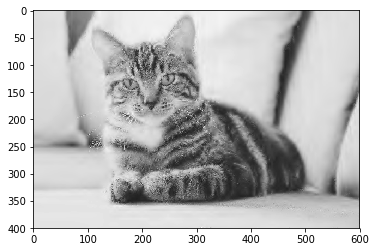

In [71]:
plt.imshow(inp_fb.x.detach(), cmap='gray')

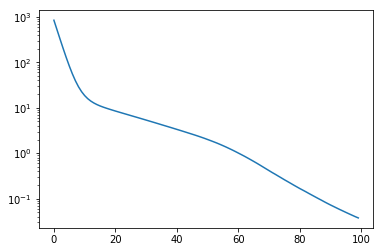

In [72]:
plt.plot(inp_fb.x_diffs)
plt.yscale('log')

In [57]:
def alpha(n):
    return (n-1)/(n+3)

In [73]:
inp_fista = Inpainting(Y, M)

In [74]:
inp_fista.run(100, 0.1, 0.1, 'db4', alpha)

tensor([[0.7822, 0.7822, 0.7822,  ..., 0.7705, 0.7703, 0.7701],
        [0.7822, 0.7822, 0.7822,  ..., 0.7704, 0.7703, 0.7701],
        [0.7822, 0.7822, 0.7822,  ..., 0.7704, 0.7702, 0.7700],
        ...,
        [0.8039, 0.8040, 0.8040,  ..., 0.7086, 0.7086, 0.7085],
        [0.8040, 0.8040, 0.8041,  ..., 0.7097, 0.7097, 0.7096],
        [0.8039, 0.8039, 0.8040,  ..., 0.7106, 0.7107, 0.7106]],
       requires_grad=True)

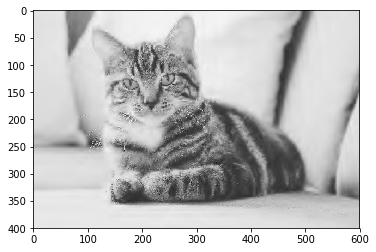

In [75]:
plt.imshow(inp_fista.x.detach(), cmap='gray')

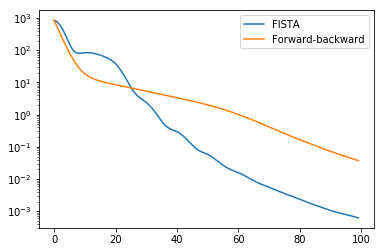

In [80]:
plt.plot(inp_fista.x_diffs, label='FISTA')
plt.plot(inp_fb.x_diffs, label='Forward-backward')
plt.yscale('log')
plt.legend()

In [64]:
inp.reset()

In [65]:
inp.run(100, 0.1, 0.1, 'db4')

tensor([[0.7815, 0.7815, 0.7815,  ..., 0.7703, 0.7701, 0.7699],
        [0.7815, 0.7815, 0.7815,  ..., 0.7703, 0.7701, 0.7699],
        [0.7815, 0.7815, 0.7815,  ..., 0.7702, 0.7701, 0.7699],
        ...,
        [0.8026, 0.8026, 0.8027,  ..., 0.7088, 0.7089, 0.7088],
        [0.8027, 0.8027, 0.8027,  ..., 0.7099, 0.7100, 0.7099],
        [0.8026, 0.8026, 0.8026,  ..., 0.7109, 0.7110, 0.7109]],
       requires_grad=True)

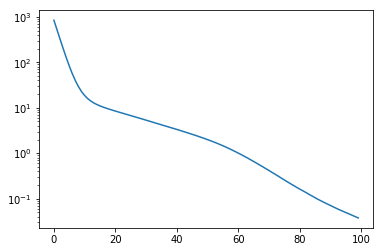

In [66]:
plt.plot(inp.x_diffs)
plt.yscale('log')

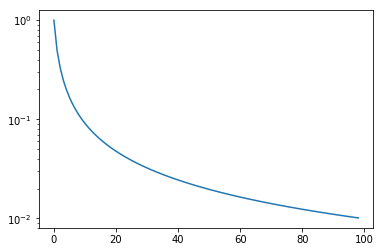

In [45]:
plt.plot(1/np.arange(1, 100))
plt.yscale('log')